In [1]:
import nibabel as nib
import pandas as pd
import os

# Your real file paths:
base_path = r"C:\Users\gifto\OneDrive\fMRI Cogs 108\local_data\sub-1001\func"

bold_path = os.path.join(base_path, "sub-1001_task-sharedreward_run-1_bold.nii.gz")
events_path = os.path.join(base_path, "sub-1001_task-sharedreward_run-1_events.txt")

print("BOLD exists:", os.path.exists(bold_path))
print("Events exists:", os.path.exists(events_path))


BOLD exists: True
Events exists: True


In [2]:
img = nib.load(bold_path)

print("Image shape:", img.shape)
print("Voxel sizes + TR (zoom values):", img.header.get_zooms())


Image shape: (80, 80, 52, 231)
Voxel sizes + TR (zoom values): (np.float32(3.0), np.float32(3.0), np.float32(3.0), np.float32(1.75))


In [4]:
events = pd.read_csv(events_path, sep="\t")

print(events.head())
print("\nColumns:", events.columns.tolist())
print("\nUnique trial types:", events["trial_type"].unique())


       onset   duration             trial_type  response_time
0   4.103763   3.532095  event_stranger_punish       1.668163
1   4.103763  33.500000  block_stranger_punish            NaN
2   8.476825   3.525949  event_stranger_punish       0.497649
3  12.829946   3.526406  event_stranger_punish       0.564864
4  17.183983   3.526835  event_stranger_punish       0.364436

Columns: ['onset', 'duration', 'trial_type', 'response_time']

Unique trial types: ['event_stranger_punish' 'block_stranger_punish' 'event_stranger_neutral'
 'event_stranger_reward' 'missed_trial' 'block_friend_reward'
 'event_friend_punish' 'event_friend_reward' 'block_stranger_reward'
 'event_friend_neutral' 'event_computer_punish' 'block_computer_punish'
 'event_computer_neutral' 'block_friend_punish' 'event_computer_reward'
 'block_computer_reward']


In [5]:
from nilearn.glm.first_level import FirstLevelModel

# Get TR (time between scans) from the image header
t_r = float(img.header.get_zooms()[3])
print("TR:", t_r)

first_level_model = FirstLevelModel(
    t_r=t_r,
    noise_model="ar1",
    standardize=True,
    hrf_model="glover",
    drift_model="cosine",
    high_pass=0.01,
)

print("Fitting GLM... this may take a bit.")
first_level_model = first_level_model.fit(bold_path, events=events)
print("GLM fit complete ✅")


TR: 1.75
Fitting GLM... this may take a bit.


C:\Users\gifto\AppData\Local\Temp\ipykernel_26860\4005967493.py:17: UserWarning: The following unexpected columns in events data will be ignored: response_time
  first_level_model = first_level_model.fit(bold_path, events=events)


GLM fit complete ✅


In [6]:
design = first_level_model.design_matrices_[0]
print(design.columns.tolist())


['block_computer_punish', 'block_computer_reward', 'block_friend_punish', 'block_friend_reward', 'block_stranger_punish', 'block_stranger_reward', 'event_computer_neutral', 'event_computer_punish', 'event_computer_reward', 'event_friend_neutral', 'event_friend_punish', 'event_friend_reward', 'event_stranger_neutral', 'event_stranger_punish', 'event_stranger_reward', 'missed_trial', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'constant']


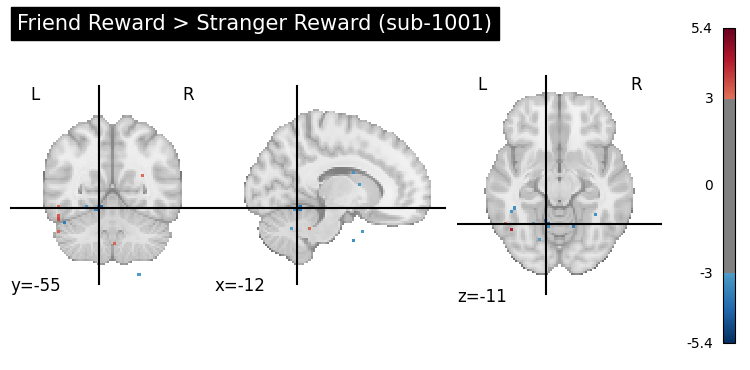

In [7]:
from nilearn import plotting

# Contrast expression using your actual column names
contrast_expr = "event_friend_reward - event_stranger_reward"

z_map = first_level_model.compute_contrast(
    contrast_expr,
    output_type="z_score"
)

plotting.plot_stat_map(
    z_map,
    threshold=3.0,
    display_mode="ortho",
    title="Friend Reward > Stranger Reward (sub-1001)"
)


In [8]:
plotting.plot_stat_map(
    z_map,
    threshold=3.0,
    display_mode="ortho",
    title="Friend Reward > Stranger Reward (sub-1001)",
    output_file="friend_vs_stranger_sub1001.png"
)


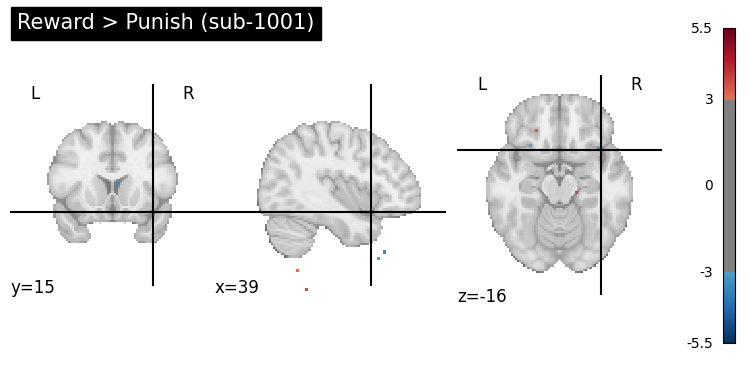

In [9]:
from nilearn import plotting

contrast_expr = (
    "event_friend_reward + event_stranger_reward + event_computer_reward "
    "- (event_friend_punish + event_stranger_punish + event_computer_punish)"
)

z_map = first_level_model.compute_contrast(
    contrast_expr,
    output_type="z_score"
)

plotting.plot_stat_map(
    z_map,
    threshold=3.0,
    display_mode="ortho",
    title="Reward > Punish (sub-1001)"
)


In [15]:
from nilearn import plotting

# 1) Friend (reward + neutral + punish)  vs  Computer (reward + neutral + punish)
contrast_expr = (
    "(event_friend_reward + event_friend_neutral + event_friend_punish) "
    "- (event_computer_reward + event_computer_neutral + event_computer_punish)"
)

z_map = first_level_model.compute_contrast(
    contrast_expr,
    output_type="z_score"
)

plotting.plot_stat_map(
    z_map,
    threshold=3.0,
    display_mode="ortho",
    title="Friend (all outcomes) > Computer (sub-1001)",
    output_file="friend_gt_computer_all_sub1001.png"   # saves the image
)



In [16]:
# 2) Social partners (Friend + Stranger) vs Non-social (Computer)
contrast_expr = (
    "(event_friend_reward + event_friend_neutral + event_friend_punish "
    "+ event_stranger_reward + event_stranger_neutral + event_stranger_punish) "
    "- (event_computer_reward + event_computer_neutral + event_computer_punish)"
)

z_map = first_level_model.compute_contrast(
    contrast_expr,
    output_type="z_score"
)

plotting.plot_stat_map(
    z_map,
    threshold=3.0,
    display_mode="ortho",
    title="Social (Friend+Stranger) > Computer (sub-1001)",
    output_file="social_gt_computer_all_sub1001.png"
)
